In [345]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from scipy import signal
from pylab import *
import os
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
fs = 256

def rd(filename):
    # filename = 'X:/3_2 运动算法资料/4_data/data.dat'
    fid = open(filename, 'rb')
    fid1 = fid.read()

    data = []
    ecg = []
    acc = []
    acc_x = []
    acc_y = []
    acc_z = []
    #根据.dat写入格式，将两个8位组合成一个数据
    for i in range(0, len(fid1), 2):
        if fid1[i] >> 7 == 1:
            data.append(((fid1[i] - pow(2, 8)) << 8) + fid1[i+1])
        else:
          data.append((fid1[i] << 8) + fid1[i+1])
    fid.close()

    #根据数据存储格式，将数组切片，前5位为ecg数据，后3位为三轴加速度数据
    for i in range(0,len(data),8):
        for j in range(5):
            ecg.append(data[i+j])
        acc_x.append(data[i+5])
        acc_y.append(data[i+6])
        acc_z.append(data[i+7])
        acc.append(np.linalg.norm( [data[i+5], data[i+6], data[i+7]], ord=2))#加速度二范数

    return ecg, acc, acc_x, acc_y, acc_z


In [346]:
# butter带通滤波
def butter_bandpass(data, fre, lowcut, highcut, order):
    nyq = 0.5 * fre
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    new_sig = signal.filtfilt(b, a, data)
    return b, a, new_sig
# 对于丢数片段，进行插值处理，权重向量计算
def interpolat(acc):
    #以下求权重向量w_i
    n = fs #需要拟合的点的数量
    w_ii = [1/(n-ii) for ii in range(n)]
    w_i = [x / sum(w_ii) for x in w_ii]
    for num in range(len(acc)):
        if acc[num] == 0:
            if num > fs:
                acc_i = acc[num-n: num]
            else:
                acc_i = acc[num+1: num+n+1]
            acc[num] = sum(np.multiply(w_i, acc_i))
    return acc

# # 设置动态阈值
def thr_mean(acc_norm): # 其中acc_norm长度为1分钟的倍数
    acc_norm2 = acc_norm.reshape(t, 1, 3072) #创建3维矩阵
    acc_mean_t = [np.mean(acc_norm2[tt, :, :]) for tt in range(t)]
    acc_mean = np.dot(np.transpose([acc_mean_t]), ones((1,3072))).reshape(t*3072)
    plt.plot(acc_norm)
    plt.plot(acc_mean)
    plt.show()
    return acc_mean

# 通过积分方法PIM计算活动量
# 具体算法1：以每分钟为计数单位，将每分钟分为6个10s片段，求6个片段中的积分最大值
def pim(acc_norm, thr):
    acc_norm = abs(acc_norm - thr)
    acc_norm = acc_norm.reshape(t, 6, 512) #创建3维矩阵
    # 计算每个epoch=10s的积分，并求最大
    delte = 1/(fs/5)
    acc_pim = []
    for epoch in range(t):
        acc_epoch = delte*sum(acc_norm[epoch, :, i] for i in range(512))
        acc_pim.append(max(acc_epoch))
    
    return acc_pim

# 过零检测模式ZCM来计算活动计数
def zcm(acc_norm, thr_zcm):
    thr_zcm = thr_zcm*ones(len(acc_norm))
    acc_zcm = acc_norm - thr_zcm
    acc_zcm = acc_zcm.reshape(t,3072) #3072为1min的采样点
    zcm_count = []
    for tt in range(t):
        c=0
        for sam in range(3071):
            if acc_zcm[tt,sam]*acc_zcm[tt,sam+1]<0:
                c+=1
        zcm_count.append(c)
    return zcm_count
# 时间阈值模式TAT来计算活动计数
def tat(acc_norm, thr_tat):
    thr_tat = thr_tat*ones(len(acc_norm))
    acc_tat = acc_norm - thr_tat
    acc_tat = acc_tat.reshape(t,3072) #3072为1min的采样点
    tat_count = []
    for tt in range(t):
        c=0
        for sam in range(3071):
            if acc_tat[tt,sam]>0:
                c+=1
        tat_count.append(c)
    return tat_count


#   Webster's算法
def webster(acc_act):
    D = list(zeros(4)) #暂时将前4分钟及后2分钟赋值为0，后面会再次赋值
    for i in range(4, t-2):
        w_d = array([0.15, 0.15, 0.15, 0.08, 0.21, 0.12, 0.13])
        a_i = array(acc_act[i-4: i+3])
        d_i = 0.025*sum(w_d * a_i)
        D.append(d_i)
    D = D + list(zeros(2))
    return D

In [347]:
# 批量读取数据
##当使用固定阈值1g时，th_sleep=28,th_deep=16 此阈值设置偏高，易把久坐不动判断为睡眠状态
# th_sleep=18,th_deep=5  此阈值设置偏低，易把睡眠状态判断为清醒
#当使用动态阈值acc_mean时,th_sleep=5,th_deep=1 仍将部分久坐判断为睡眠，那么考虑频谱分析
# path = "F:/工作任务/睡眠监测/data/CA-30-F3-FF-FE-CD2-9/9403"#文件夹目录 
path = "F:/工作任务/睡眠监测/data/2018/2/10/FC-00-00-00-00-4F/43509" 
# path = "F:/工作任务/睡眠监测/data/2018/2/4/FC-00-00-00-00-4F/43284" 
# path = "F:/工作任务/睡眠监测/data/FC-00-00-00-00-4F/9442" 
# path = "F:/工作任务/睡眠监测/data/FC-00-00-00-00-4F/9443" 
# path = "F:/工作任务/睡眠监测/data/FC-00-00-00-00-4F/9445" 
# path = "F:/工作任务/睡眠监测/data/FC-00-00-00-00-4F/9454" 
# path = "F:/工作任务/睡眠监测/data/14/FC-00-00-00-00-4F/9701"
# path = "F:/工作任务/睡眠监测/data/2018/3/21/FC-00-00-00-00-4F/9859"
# path = "F:/工作任务/睡眠监测/data/2018/3/21/FC-00-00-00-00-4F/9860"
# path = "F:/工作任务/睡眠监测/data/2018/3/21/FC-00-00-00-00-4F/9862"
# path = "X:/3_2 运动算法资料/4_data/Text2018-02-06/FC-00-00-00-00-4F/43285"



files = os.listdir(path) #得到文件夹下的所有文件名称
acc_norm = []
acc_x = []
acc_y = []
acc_z = []
for file in files:#遍历文件夹
    file = os.path.join(path, file)
    if os.path.isdir(file): #判断是否是文件夹，是文件夹才打开
        filename = file + "/" + "data.dat" #data.dat文件目录
        data = rd(filename)[1] #调用data_reading模块，返回加速度二范数（共5个返回值中的第2个）
#         data_x = rd(filename)[2]
#         data_y = rd(filename)[3]
#         data_z = rd(filename)[4]
        
        acc_norm.extend(data)
#         acc_x.extend(data_x)
#         acc_y.extend(data_y)
#         acc_z.extend(data_z)
        

# 读取单个文件数据
# filename = "F:/工作任务/睡眠监测/data/CA-30-F3-FF-FE-CD2-9/9403/18-02-09 05-33-20/data.dat"
# acc_norm = data_reading.rd(filename)[1]



In [348]:
# 将加速度数据存为txt，移植c用
# f = open(path+"/" +'43285.txt', 'w')
# f.write(str(acc_norm))
# f.close

np.savetxt('X:/3_2 运动算法资料/4_data/Text2018-02-06/FC-00-00-00-00-4F/43285/43285.txt', acc_norm)


In [349]:
# 读取起始文件名，获得监测时间

def t2s(t):
    h,m,s = t.strip().split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)
def t2m(t):
    h,m,s = t.strip().split(":")
    return int(h) * 60 + int(m) 
def s2t(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return "%02d:%02d:%02d" % (h, m, s)
def m2t(minutes):
    h, m = divmod(minutes, 60)
    s = 0
    if h >=24:
        h-=24
    return "%02d:%02d" % (h, m)

t_start = files[0][9:].replace('-',':')
m_start = t2m(t_start)
s_start = t2s(t_start)
print(t_start)
print(m_start)
print(s_start)

00:18:22
18
1102


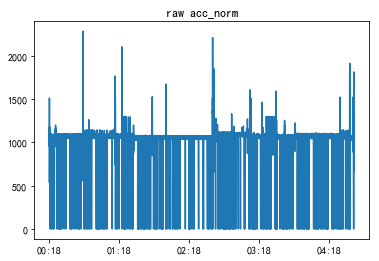

In [350]:
axis_s = range(m_start*3072,m_start*3072+len(acc_norm))

plt.xticks([tt for tt in range(m_start*3072,m_start*3072+len(acc_norm),3072*60)],
  [m2t(tt/3072) for tt in range(m_start*3072,m_start*3072+len(acc_norm),3072*60)])

plt.title("raw acc_norm")
plt.plot(axis_s, acc_norm)
plt.show()



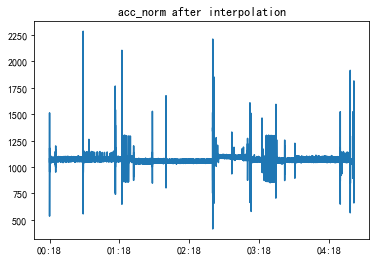

In [351]:
#对于丢数的片段（最长不超过5s），通过插值法补数

acc_norm = interpolat(acc_norm)

plt.title("acc_norm after interpolation")
plt.xticks([tt for tt in range(m_start*3072,m_start*3072+len(acc_norm),3072*60)],
  [m2t(tt/3072) for tt in range(m_start*3072,m_start*3072+len(acc_norm),3072*60)])


plt.plot(axis_s, acc_norm)
plt.show()

# plt.title("acc_x")
# plt.plot(interpolat(acc_x))
# plt.show()
# plt.title("acc_y")
# plt.plot(interpolat(acc_y))
# plt.show()
# plt.title("acc_z")
# plt.plot(interpolat(acc_z))
# plt.show()

In [352]:
temp_x=[0,0,0,0,0,0,0]
temp_y=[0,0,0,0,0,0,0]
butter_i=0
y=0
def butter_bandpass_by_one(x):
    global y
    global butter_i
#     b = [0.6404957,0.,-1.92148711,0.,1.92148711,0., -0.6404957]
#     a = [1.,0.09825509, -2.11845638, -0.11905002,1.58884383,0.04037319,-0.41018215]
    b = [0.10454208, 0., -0.31362623, 0., 0.31362623, 0., -0.10454208]
    a = [ 1., -3.3496998, 4.54411275, -3.46002677, 1.74365223, -0.52770977, 0.0498888]

    temp_x[6] = temp_x[5]
    temp_x[5] = temp_x[4]
    temp_x[4] = temp_x[3]
    temp_x[3] = temp_x[2]
    temp_x[2] = temp_x[1]
    temp_x[1] = temp_x[0]
    temp_x[0] = x

    if(butter_i<6):
        butter_i+=1
        return 0
    
    y = y + b[0]*temp_x[0]+b[1]*temp_x[1]+b[2]*temp_x[2]+b[3]*temp_x[3]+b[4]*temp_x[4]+b[5]*temp_x[5]+b[6]*temp_x[6]

    y = y - a[1]*temp_y[1]-a[2]*temp_y[2]-a[3]*temp_y[3]-a[4]*temp_y[4]-a[5]*temp_y[5]-a[6]*temp_y[6]

    temp_y[6] = temp_y[5]
    temp_y[5] = temp_y[4]
    temp_y[4] = temp_y[3]
    temp_y[3] = temp_y[2]
    temp_y[2] = temp_y[1]
    temp_y[1] = y
    return y

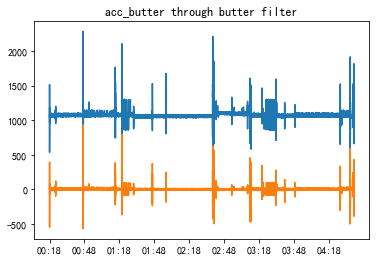

b: [ 0.10454208  0.         -0.31362623  0.          0.31362623  0.
 -0.10454208]
a: [ 1.         -3.3496998   4.54411275 -3.46002677  1.74365223 -0.52770977
  0.0498888 ]


array([ 6.14051748e+00,  2.38859299e+00, -4.29588077e+00, -8.06897090e+00,
       -5.54319959e+00,  1.48965158e-01,  3.40485654e+00,  2.31032321e+00,
       -5.60470438e-01, -2.36570312e+00, -3.26543841e+00, -4.72927761e+00,
       -6.13685137e+00, -5.33085007e+00, -1.89991501e+00,  2.07159823e+00,
        4.12256318e+00,  3.32946769e+00,  8.23594761e-01, -1.32520292e+00,
       -2.15860123e+00, -1.88350986e+00, -5.67611191e-03,  3.83973837e+00,
        7.02761085e+00,  5.78690349e+00,  7.84282612e-01, -2.76387143e+00,
       -1.65509795e+00,  1.64224970e+00,  3.03252256e+00,  1.84095945e+00,
        1.58618120e-01, -8.12896344e-01, -1.43980056e+00, -1.65115014e+00,
       -7.95998940e-01,  3.85539293e-01,  1.70026092e-01, -9.28374891e-01,
       -3.12710196e-01,  1.89462279e+00,  2.19369044e+00, -2.43911939e-01,
       -1.69175719e+00,  2.24665536e-01,  3.39227103e+00,  4.63627664e+00,
        2.70105076e+00, -1.54871574e+00, -5.34692988e+00, -5.61742979e+00,
       -2.25653220e+00,  

In [353]:
# 进行butter带通滤波
data = acc_norm
fre = 51.2
lowcut = 0.5
highcut = 11
order = 3
acc_norm_butter=[]
b, a, acc_norm_butter = butter_bandpass(data, fre, lowcut, highcut, order)
plt.title("acc_butter through butter filter")
plt.xticks([tt for tt in range(m_start*3072,m_start*3072+len(acc_norm),3072*30)],
  [m2t(tt/3072) for tt in range(m_start*3072,m_start*3072+len(acc_norm),3072*30)])

plt.plot(axis_s, acc_norm)
plt.plot(axis_s, acc_norm_butter)
plt.show()

acc_norm = acc_norm_butter

print('b:',b)
print('a:',a)
acc_norm[10000:10100]




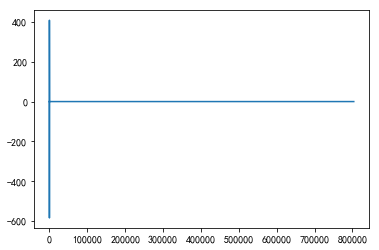

(803580,)


In [354]:

fid = open('X:/3_2 运动算法资料/4_data/Text2018-02-06/FC-00-00-00-00-4F/43285/43285_c.txt', 'r')
# acc_c = fid.read()
# fid.close
# acc_c[100]

df = pd.read_csv(fid,encoding = 'utf-8',header=None)#因为路径含中文，故不能直接读
# acc_c = df.values
acc_c = np.array(df)
acc_c = acc_c.reshape(len(acc_c))
fid.close()

plt.plot(acc_c )
plt.show()

print(shape(acc_c))

acc_norm = acc_c

In [355]:
acc_c[10000:10100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [356]:
# 活动计数

# 通过积分方法PIM计算活动量
# 具体算法1：以每分钟为计数单位，将每分钟分为6个10s片段，求6个片段中的积分最大值
num_epoch = int(len(acc_norm)/(2*fs)) #10 s片段数量
t = int(num_epoch/6) #1 minute片段数量
acc_norm = array(acc_norm[:int(12*fs*t)])


# 通过积分方法PIM计算活动量
thr_h = 0 #设置固定阈值为0
# thr = thr_mean(acc_norm)
thr = thr_h*ones(len(acc_norm))#带通滤波后，选择0为阈值
acc_pim = pim(acc_norm, thr)

# 通过过零点ZCM计算活动量
thr_zcm = 30
acc_zcm = zcm(acc_norm, thr_zcm)

# 通过时间窗口模式TAT计算活动量
thr_tat = 30
acc_tat = tat(acc_norm, thr_tat)




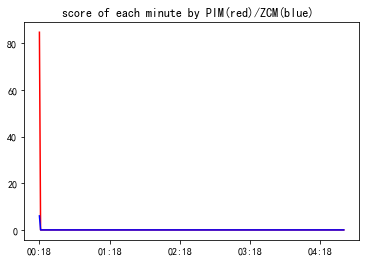

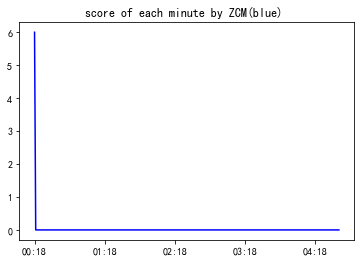

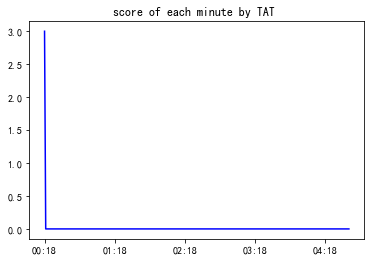

In [357]:
#更新横坐标
axis_m = range(m_start,t+m_start)
# axis_t = [m2t(a) for a in axis_m]

# ax1=plt.subplot(111)
# xmajorLocator = MultipleLocator(60)
# ax.xaxis.set_major_locator(xmajorLocator) 

# 做映射，设置x刻度：用axis_t来显示刻度
plt.title("score of each minute by PIM(red)/ZCM(blue) ")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])

plt.plot(axis_m, acc_pim, 'r')
plt.plot(axis_m, acc_zcm, 'b')
# plt.savefig("活动量-PIM")
plt.show()

plt.title("score of each minute by ZCM(blue) ")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])

plt.plot(axis_m, acc_zcm, 'b')
# plt.savefig("活动量-PIM")
plt.show()

plt.title("score of each minute by TAT ")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])

plt.plot(axis_m, acc_tat, 'b')
plt.show()

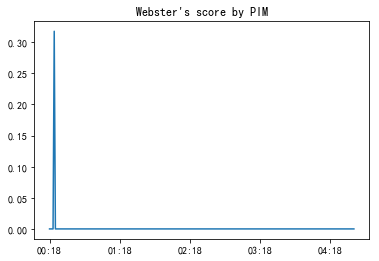

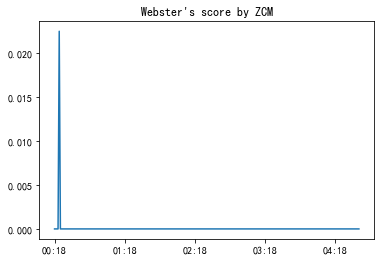

In [358]:
#   Webster's算法 D = 0.025(0.15A_4 + 0.15A_3 + 0.15A_2 + 0.08A_l + 0.21Ao + 0.12A+l + 0.13A+2)
# acc_act = acc_pim #积分法计数获得的按分钟活动量
# acc_act = acc_zcm #过零点法计数获得的按分钟活动量
                     
D_pim = webster(acc_pim)
D_zcm = webster(acc_zcm)

plt.title("Webster's score by PIM")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, D_pim)
plt._show()

plt.title("Webster's score by ZCM")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, D_zcm)
plt._show()

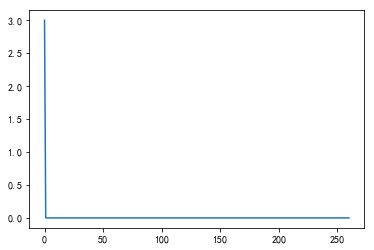

(261,)


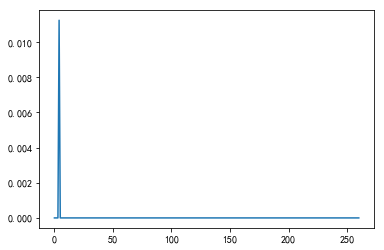

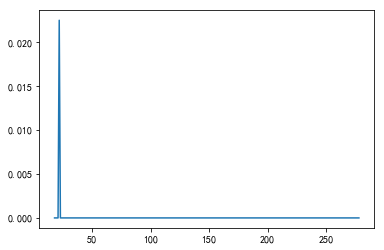

In [359]:
#验证c输出的count_zcm,score_zcm
filename = "X:/3_2 运动算法资料/4_data/Text2018-02-06/FC-00-00-00-00-4F/43285/43285_count.txt"
fid = open(filename, 'r')

df = pd.read_csv(fid,encoding = 'utf-8',header=None)#因为路径含中文，故不能直接读
count_zcm = np.array(df)
count_zcm = count_zcm.reshape(len(count_zcm))
fid.close()
plt.plot(count_zcm)
plt.show()

print(shape(count_zcm))


filename = "X:/3_2 运动算法资料/4_data/Text2018-02-06/FC-00-00-00-00-4F/43285/43285_zcm.txt"
fid = open(filename, 'r')

df = pd.read_csv(fid,encoding = 'utf-8',header=None)#因为路径含中文，故不能直接读
score_zcm = np.array(df)
score_zcm = score_zcm.reshape(len(score_zcm))
fid.close()
plt.plot(score_zcm)
plt.show()


plt.plot(axis_m, D_zcm)
plt._show()
shape(D_zcm)

D_zcm = score_zcm

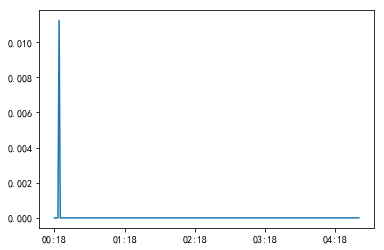

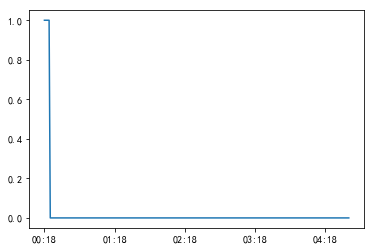

dict_values([0.0, 0.0, 0.0, 0.0, 0.01125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [360]:
th_sleep = 0.8 #将sleep/wake阈值设置为20
th_deep = 0.0001 #将deep/light-sleep阈值设置为10
dic_D = {t: D_zcm[t] for t in range(t)}

dic_score = dic_D.copy() #字典浅复制
for i in range(4): #Webster's算法未计算的前4分钟状态同第5分钟
    dic_score[i] = dic_score[4]
for i in range(t-2,t): # 最后2分钟状态同前一分钟
    dic_score[i] = dic_score[t-3]


for key in dic_score.keys():
    if  dic_score[key] > th_sleep:
        dic_score[key] = 2
    elif dic_score[key] > th_deep:
        dic_score[key] = 1
    else:
        dic_score[key] = 0
    # print(dic_score[key])
    
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_D.values())
plt.show()
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_score.values())
plt.show()
dic_D.values()


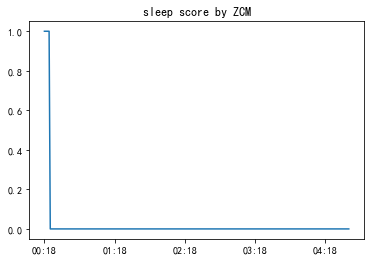

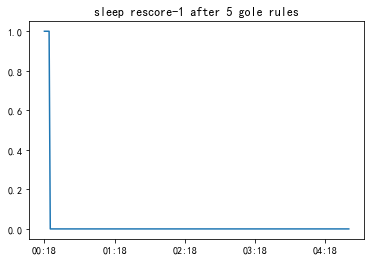

From 00:18 enter sleep monitoring program...


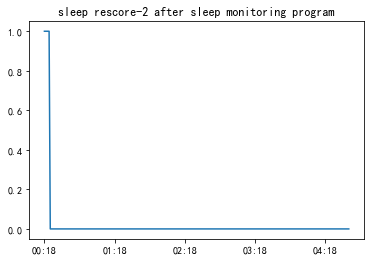

In [361]:
#  因刚开始入睡时，在PSG检测到进入睡眠状态1时，人体已经停止动作静止；故设置此重新评分法则：
# (a) After at least 4 minutes scored as wake, the next 1 minute scored as sleep is rescored wake;
# (b) after at least 10 minutes scored as wake, the next 3 minutes scored as sleep are rescored wake;
# (c) after at least 15 minutes scored as wake, the next 4 minutes scored as sleep are rescored wake;
# (d) 6 minutes or less scored as sleep surrounded by at least 10 minutes (before and after) scored as wake are rescored wake;
# (e) 10 minutes or less scored as sleep surrounded by at least 20 minutes (before and after) scored as wake are rescored wake.       
dic_rescore = dic_score.copy()
for key in dic_rescore.keys(): # rule (a)
    if (key > 3 and all([dic_rescore[key-i] == 2 for i in range(1,5)])and dic_rescore[key] < 2 ):
        dic_rescore[key] = 2
        break

#         i = 1
#         while(i<5):
#             if dic_rescore[key-i] == 2:
#                 i+=1
#             else:
#                 break
#         if(i == 4):
#              dic_rescore[key] = 2
# plt.plot(array(range(t-6))/60, dic_rescore.values())
# plt.show()    
for key in dic_rescore.keys():# rule (b)
    if (key > 9 and key < len(dic_rescore)-3 and all([dic_rescore[key - i] == 2 for i in range(1, 11)])and dic_rescore[key + 1] < 2):
        for i in range(1, 4):
            dic_score[key+i] = 2
        break
                
for key in dic_rescore.keys():# rule (c)
    if (key > 14 and key < len(dic_rescore)-4 and all([dic_rescore[key - i] == 2 for i in range(1, 16)])and dic_rescore[key + 1] < 2):
        for i in range(1, 5):
            dic_score[key+i] = 2
        break
                
for key in dic_rescore.keys():# rule (d)
    if (key > 9 and key < len(dic_rescore)-15 and all([dic_rescore[key-i] == 2 for i in range(1,11)])and dic_rescore[key + 1] < 2):
        i=2
        while(i<=6):
            if dic_rescore[key+i] < 2:
                i+=1
            else:
                break
        if all([dic_rescore[key + i + ii] == 2 for ii in range(1,11)]):
            for ii in range(1,i):
                dic_rescore[key+i-ii] = 2
                
for key in dic_rescore.keys():# rule (e)
    if (key > 19 and key < len(dic_rescore)-29 and all([dic_rescore[key-i] == 2 for i in range(1,21)])and dic_rescore[key + 1] < 2):
        i=2
        while(i<=10):
            if dic_rescore[key+i] < 2:
                i+=1
            else:
                break
        if all([dic_rescore[key + i + ii] == 2 for ii in range(1,21)]):
            for ii in range(1,i):
                dic_rescore[key+i-ii] = 2
# plt.subplot(211)
plt.title("sleep score by ZCM")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_score.values())
plt.show()
                
                
plt.title("sleep rescore-1 after 5 gole rules")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_rescore.values())
plt.show()

# print(list(dic_rescore.values()).count(1))
# print(dic_rescore.values())
# key = 9
# if ( key < len(dic_rescore)-60 and all([dic_rescore[key + i] < 2 for i in range(1,61)])):
#     print("yes")

#判断是否进入睡眠程序:检测到连续30/60分钟睡眠才进入睡眠监测程序——待模块化！！！

monitor = 0

for key in dic_rescore.keys():
    if ( key < len(dic_rescore)-60 and all([dic_rescore[key + i] < 2 for i in range(1,61)])):
        for tt in range(1,key):
            dic_rescore[key - tt] == 2 
        print("From", m2t(m_start+key), "enter sleep monitoring program...")
        monitor = 1
        break
if(monitor == 0):
    dic_rescore = {t: 2 for t in range(t)}

# 深睡浅睡规则待完善 ！！！


# plt.subplot(212)
plt.title("sleep rescore-2 after sleep monitoring program")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_rescore.values())
plt.show()

In [362]:
dic_score.values()

dict_values([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

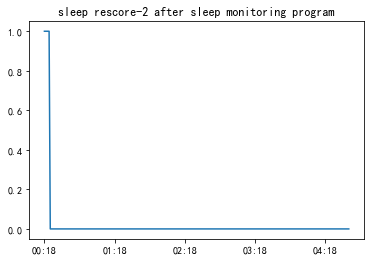

Time to fall sleep: 00:18
Time of sleep: 4.35 hours
Time of deep sleep: 4.27 hours
Time of light sleep: 0.08 hours


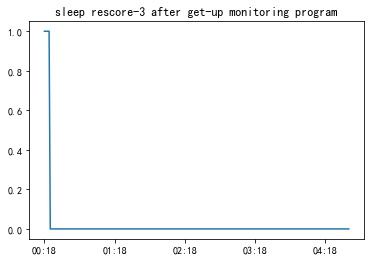

In [363]:
# plt.subplot(212)
plt.title("sleep rescore-2 after sleep monitoring program")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_rescore.values())
plt.show()

# 睡眠指标统计：入睡时间time_fall， 起床时间time_get， 睡眠总时长t_sleep, 深睡眠时长t_deep， 浅睡眠时长t_light，睡眠过程中清醒时长t_wake


#如果检测点前10分钟清醒,检测点后10分钟睡眠，这判定为入睡时间点
for key in dic_rescore.keys():
    if dic_rescore[key]<2:
        if (key > 9 and key < len(dic_rescore)-10 and all([dic_rescore[key-i] == 2 for i in range(1,11)]) and all([dic_rescore[key+i] < 2 for i in range(1,11)])):
            time_fall = m2t(key+m_start)
            print("Time to fall sleep:", time_fall)
            break
        if (key < 9 or key > len(dic_rescore)-10):
            time_fall = m2t(key+m_start)
            print("Time to fall sleep:", time_fall)
            break
# 相反的，如果检测点前10分钟睡眠，检测点后10分钟清醒，则判定为起床时间点
for key in dic_rescore.keys():
    if (key > 9 and key < len(dic_rescore)-10 and dic_rescore[key] == 2 and all([dic_rescore[key-i] < 2 for i in range(1,11)]) and all([dic_rescore[key+i] == 2 for i in range(1,11)])):
        time_get = m2t(key+m_start)
        print("Time to get up:", time_get, ",and out of sleep monitoring program.")
        #退出睡眠监测程序，并重新检测入睡时间点，即起床后——未进入睡眠程序前的点赋值为2，此模块待完善！！！
        for kk in range(key, t):
            dic_rescore[kk] = 2
#           print(dic_rescore[key])
        break

# 睡眠过程中的清醒时长，如果检测点前10分钟睡眠，清醒时间段后10分钟睡眠，则判定为睡眠过程中清醒 
for key in dic_rescore.keys():
    if (key > 9 and key < len(dic_rescore)-10 and dic_rescore[key] == 2 and all([dic_rescore[key-i] < 2 for i in range(1,11)])):
        wake_in_sleep = 0
        while (key+wake_in_sleep < len(dic_rescore)-10):
            if (dic_rescore[key+wake_in_sleep] == 2):
                wake_in_sleep+=1
            else:
                break
        if all([dic_rescore[key+wake_in_sleep+i] < 2 for i in range(1,10)]):
            print("Wake time during sleep:", m2t(key+wake_in_sleep+m_start))
            print("The length of wake time during sleep:", wake_in_sleep,"minutes")
     
t_deep = list(dic_rescore.values()).count(0)/60
t_light = list(dic_rescore.values()).count(1)/60
t_wake = list(dic_rescore.values()).count(2)/60
t_sleep = t_deep + t_light


print("Time of sleep:", '%.2f' % t_sleep, "hours")
print("Time of deep sleep:", '%.2f' % t_deep,"hours")
print("Time of light sleep:", '%.2f' % t_light,"hours")
# print("Time of wake:", '%.2f' % t_wake,"hours")

plt.title("sleep rescore-3 after get-up monitoring program")
plt.xticks([tt for tt in range(m_start,t+m_start,60)],
  [m2t(tt) for tt in range(m_start,t+m_start,60)])
plt.plot(axis_m, dic_rescore.values())
plt.show()